In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify 

In [2]:
# variable and dictionary
year = 2020
states_dict = {'Rakousko':'AT', 
               'Belgie':'BE', 
               'Bulharsko':'BG',
               'Kypr':'CY',
               'České Republika':'CZ',
               'Německo':'DE',
               'Dánsko':'DK',
               'Estonsko':'EE',
               'Špenělsko':'ES',
               'Finsko':'FI',
               'Francie':'FR',
               'Chorvatsko':'HR',
               'Maďarsko':'HU',
               'Irsko':'IE',
               'Itálie':'IT',
               'Litva':'LT',
               'Lucembursko':'LU',
               'Lotyšsko':'LV',
               'Malta':'MT',
               'Nizozemsko':'NL',
               'Polsko':'PL',
               'Portugalsko':'PT',
               'Rumunsko':'RO',
               'Švédsko':'SE',
               'Slovinsko':'SI',
               'Slovensko':'SK',}

In [3]:
# get emission data
def _get_emis_data(year, states_dict):
    """Import data from Eurostat,
    rename columns, select certain data.
    """
    df_sorce_emis = eurostat.get_data_df('env_air_gge')
    df_emis = df_sorce_emis.rename(columns={'geo\\time': 'geo'})
    df_emis = df_emis.query("src_crf == 'TOTX4_MEMONIA' and unit == 'MIO_T' and airpol == 'GHG'")
    df_emis = df_emis.loc[df_emis['geo'].isin(states_dict.values())] # add states according to states_dict
    df_emis = df_emis[["geo", year]]
    return df_emis

In [4]:
# get demography data
def _get_demo_data(year, states_dict):
    """Import data from Eurostat,
    rename columns, select certain data.
    """
    df_sorce_demo = eurostat.get_data_df('demo_pjan')
    df_demo = df_sorce_demo.rename(columns={'geo\\time': 'geo'})
    df_demo = df_demo.query("age == 'TOTAL' and sex == 'T'")
    df_demo = df_demo.loc[df_demo['geo'].isin(states_dict.values())] # add states according to states_dict
    df_demo = df_demo[["geo", year]]
    return df_demo

In [5]:
# merge dataframes
def _merge_df(year, df_emis, df_demo, states_dict):
    """merge dataframes,
    adjust dataframe.
    """
    # merge df
    df_merged = df_emis.merge(df_demo, on='geo', suffixes=('_emis', '_popul')) # "suffixes" rename columns 
    
    # adjust df
    df_merged['em_na_oby'] = (df_merged[f'{year}_emis'] * 1000000) / df_merged[f'{year}_popul']
    df_merged['stat'] = states_dict.keys()
    df_merged = df_merged.set_index('stat')
    df_merged = df_merged.sort_values(f'{year}_emis', ascending = False)
    return df_merged

In [6]:
# draw the treemap plot
def _draw_treemap_plot(year, df_merged):
    """set color scale,
    create plot.
    """
    # define colors
    cmap = matplotlib.cm.viridis # choose color scale
    mini=min(df_merged[f'{year}_emis'])
    maxi=max(df_merged[f'{year}_emis'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df_merged[f'{year}_emis']]
   
    # plot properties
    squarify.plot(df_merged[f'{year}_emis'], label=df_merged.index, alpha=0.8, color=colors)
    plt.title(f"Celkové roční emise států EU za rok {year} v milionech tun CO2 ekv.")
    plt.axis("off")
    
    # show plot
    plt.show()

In [7]:
# draw the horizontal bar plot
def _draw_barh_plot(year, df_merged):
    """create plot"""   
    
    # sort df 
    df_merged.sort_values(by='em_na_oby', ascending=False, inplace=True)

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_merged.index, [0] * df_merged.index.size)
    # add emission value labels on the left.        
    plt.bar_label(fake_bar, labels=[f'{x}' for x in df_merged['em_na_oby'].round(1).sort_values()], padding=-30, fontsize=9)
    # add country name labels on the right.
    plt.bar_label(fake_bar, labels=df_merged.index[::-1], padding=3, fontsize=10)

    # show plot
    df_merged['em_na_oby'].sort_values().plot.barh(figsize=(7,6), color="lightsteelblue")
    plt.title(f'Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU za rok {year}.')
    plt.axis("off")

In [8]:
# summary function
def create_plots(year, states_dict):
    """Call functions together"""
    # get data
    df_emis = _get_emis_data(year, states_dict)
    df_demo = _get_demo_data(year, states_dict)
   
    # merge dataframes
    df_merged = _merge_df(year, df_emis, df_demo, states_dict) 

    # draw plots
    _draw_treemap_plot(year, df_merged)
    _draw_barh_plot(year, df_merged)

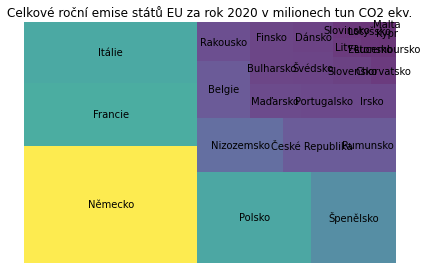

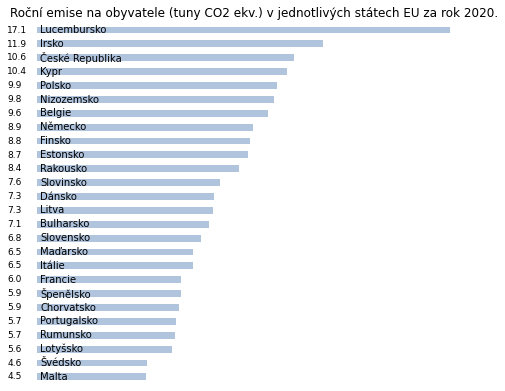

In [9]:
# CALL THE MAIN FUNCTION
create_plots(year, states_dict)